## **Data Retrieval from TCGA, Pre-processing, Differential Gene Expression (DGE) Analysis, and Functional Enrichment Analysis**  
**Cancer type :** TCGA-COAD (Colon Adenocarcinoma)

### **Data Retrieval from TCGA using TCGAbiolinks**

In [ ]:
##Install packages
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("TCGAbiolinks")
BiocManager::install("edgeR")
BiocManager::install("EDASeq")
BiocManager::install("limma")
BiocManager::install("sesameData")

install.packages('gplots')
install.packages("pheatmap")
install.packages("SummarizedExperiment")
install.packages("ggrepel")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Installing package(s) 'BiocVersion', 'TCGAbiolinks'

also installing the dependencies ‘plogr’, ‘png’, ‘Biostrings’, ‘RSQLite’, ‘KEGGREST’, ‘filelock’, ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘matrixStats’, ‘abind’, ‘SparseArray’, ‘AnnotationDbi’, ‘BiocFileCache’, ‘BiocGenerics’, ‘GenomeInfoDb’, ‘XVector’, ‘R.oo’, ‘R.methodsS3’, ‘MatrixGenerics’, ‘Biobase’, ‘S4Arrays’, ‘DelayedArray’, ‘downloader’, ‘biomaRt’, ‘GenomicRanges’, ‘XML’, ‘plyr’, ‘IRanges’, ‘S4Vectors’, ‘R.utils’, ‘SummarizedExperiment’, ‘TCGAbiolinksGUI.data’


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' f

In [2]:
## load libraries
library(TCGAbiolinks)
library(pheatmap)
library(SummarizedExperiment)
library(edgeR)
library(EDASeq)
library(limma)
library(sesameData)
library(gplots)
library(ggrepel)

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, ro

##**Preprocessing of Colon Adenocarcinoma (TCGA-COAD) data**

Followed these steps to get data from TCGA using TCGAbiolonks package

getProjectSummary() -> GDCquery() -> getResults() -> GDCdownload() -> GDCprepare()

In [3]:
# get sumamry of TCGA-COAD project
getProjectSummary("TCGA-COAD")

,file_count,case_count,data_category
,<int>,<int>,<chr>
1,7565,461,Simple Nucleotide Variation
2,3607,460,Sequencing Reads
3,2835,461,Biospecimen
4,995,461,Clinical
5,5344,460,Copy Number Variation
6,1978,459,Transcriptome Profiling
7,1665,457,DNA Methylation
8,363,360,Proteome Profiling
9,46,23,Somatic Structural Variation


### Build a query for TCGA-COAD

In [4]:
# build a query to downlaod data
query_TCGA <- GDCquery(project = "TCGA-COAD",
                        data.category = "Transcriptome Profiling",
                        experimental.strategy = "RNA-Seq",
                        workflow.type = "STAR - Counts",
                        access = "open",
                        sample.type = c("Solid Tissue Normal", "Primary Tumor")
                        )

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-COAD

--------------------

oo Filtering results

--------------------

ooo By access

ooo By experimental.strategy

ooo By workflow.type

ooo By sample.type

----------------

oo Checking data

----------------

ooo Checking if there are duplicated cases

ooo Checking if there are results for the query

-------------------

o Preparing output

-------------------



### Get results from the query (this step takes some time)

In [5]:
#get results of the query
output_query_TCGA <- getResults(query_TCGA)


#GDCdownload(query_TCGA)

### Using the query results and extract only 20 normal and 20 tumor samples

In [6]:
# from output_query_TCGA results extract only First 20 Solid Tissue Normal and 20 Primary Tunor samples
normal_samples <- output_query_TCGA[output_query_TCGA$sample_type == "Solid Tissue Normal", ][1:20, ]
tumor_samples <- output_query_TCGA[output_query_TCGA$sample_type == "Primary Tumor", ][1:20, ]

#combine normal and tumor samples
combined_samples <- rbind(normal_samples, tumor_samples)
combined_samples <-combined_samples[, c("cases", "sample_type")]

# creating a list of all sample cases in combined_samples
sample_barcodes <- as.character(combined_samples[["cases"]])
sample_barcodes


[1] "TCGA-AA-3662-11A-01R-1723-07" "TCGA-AA-3531-11A-01R-A32Z-07"
 [3] "TCGA-AZ-6603-11A-02R-1839-07" "TCGA-AZ-6599-11A-01R-1774-07"
 [5] "TCGA-AA-3655-11A-01R-1723-07" "TCGA-A6-5665-11A-01R-1653-07"
 [7] "TCGA-A6-2686-11A-01R-A32Z-07" "TCGA-A6-5659-11A-01R-1653-07"
 [9] "TCGA-A6-2684-11A-01R-A32Z-07" "TCGA-AZ-6598-11A-01R-1774-07"
[11] "TCGA-AA-3517-11A-01R-A32Z-07" "TCGA-AA-3516-11A-01R-A32Z-07"
[13] "TCGA-AA-3514-11A-01R-A32Z-07" "TCGA-A6-2675-11A-01R-1723-07"
[15] "TCGA-A6-2679-11A-01R-A32Z-07" "TCGA-A6-2671-11A-01R-A32Z-07"
[17] "TCGA-AA-3518-11A-01R-1672-07" "TCGA-A6-2683-11A-01R-A32Z-07"
[19] "TCGA-AA-3660-11A-01R-1723-07" "TCGA-A6-2682-11A-01R-A32Z-07"
[21] "TCGA-AA-3692-01A-01R-0905-07" "TCGA-AA-A00L-01A-01R-A002-07"
[23] "TCGA-G4-6625-01A-21R-1774-07" "TCGA-AA-3522-01A-01R-0821-07"
[25] "TCGA-CM-4750-01A-01R-1410-07" "TCGA-AA-3554-01A-01R-0826-07"
[27] "TCGA-AA-3561-01A-01R-0821-07" "TCGA-G4-6307-01A-11R-1723-07"
[29] "TCGA-A6-6781-01A-22R-A278-07" "TCGA-AY-A8YK-01A-11R-A41B-07"
[31] "TCGA-F4-6703-01A-11R-1839-07" "TCGA-AD-6965-01A-11R-1928-07"
[33] "TCGA-A6-6781-01B-06R-A277-07" "TCGA-AA-A029-01A-01R-A00A-07"
[35] "TCGA-AA-3510-01A-01R-1410-07" "TCGA-AY-A71X-01A-12R-A37K-07"
[37] "TCGA-CM-5341-01A-01R-1410-07" "TCGA-F4-6809-01A-11R-1839-07"
[39] "TCGA-A6-2678-01A-01R-0821-07" "TCGA-A6-6653-01A-11R-1774-07"

### Prepare sample metadata from combined_samples and download it into a csv

In [7]:
#store combined samples data into a dataframe where cases are rownames
coad_metadata <- data.frame("sample_names"=combined_samples$cases,"sample_type"=combined_samples$sample_type, row.names = 1)
head(coad_metadata)

#write metadata into a csv file
write.csv(coad_metadata , "COAD_Metadada.csv", row.names = FALSE)

,sample_type
,<chr>
TCGA-AA-3662-11A-01R-1723-07,Solid Tissue Normal
TCGA-AA-3531-11A-01R-A32Z-07,Solid Tissue Normal
TCGA-AZ-6603-11A-02R-1839-07,Solid Tissue Normal
TCGA-AZ-6599-11A-01R-1774-07,Solid Tissue Normal
TCGA-AA-3655-11A-01R-1723-07,Solid Tissue Normal
TCGA-A6-5665-11A-01R-1653-07,Solid Tissue Normal


### Using sample barcodes build another query to download only 40 samples (20 normal and 20 tumor).

In [8]:
# now using these sample_names download only 40 samples from the entire dataset
query_TCGA2 <- GDCquery(project = 'TCGA-COAD',
                      data.category = 'Transcriptome Profiling',
                      experimental.strategy = 'RNA-Seq',
                      workflow.type = 'STAR - Counts',
                      access = 'open',
                      barcode = sample_barcodes)

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-COAD

--------------------

oo Filtering results

--------------------

ooo By access

ooo By experimental.strategy

ooo By workflow.type

ooo By barcode

----------------

oo Checking data

----------------

ooo Checking if there are duplicated cases

ooo Checking if there are results for the query

-------------------

o Preparing output

-------------------



Get query results and download 20 normal and 20 tumor samples

In [9]:
#get results for query
output_query_TCGA2 <- getResults(query_TCGA2)

# download 20 normal 20 tumor samples
GDCdownload(query_TCGA2)


GDCdownload will download 40 files. A total of 169.075156 MB




Downloading: 40 MB     

### Prepare query, use unstranded assay and download COAD rawdata into csv for further analysis

In [10]:
#prepare query
tcga_coad_data <- GDCprepare(query_TCGA2, summarizedExperiment = TRUE)

#use unstranded assay from available assays in SummarizedExperiment
coad_matrix <- assay(tcga_coad_data, "unstranded")

#write tcga-code matrix data into a csv file
write.csv(coad_matrix, "COAD_Matrix.csv")

|====================================================|100%                      Completed after 5 s 


Starting to add information to samples

 => Add clinical information to samples

 => Adding TCGA molecular information from marker papers

 => Information will have prefix 'paper_' 

coad subtype information from:doi:10.1038/nature11252

Available assays in SummarizedExperiment : 
  => unstranded
  => stranded_first
  => stranded_second
  => tpm_unstrand
  => fpkm_unstrand
  => fpkm_uq_unstrand



### **Check if colnames of coad_matrix and rownames of coad_metadata match**

In [11]:
# Find colnames in coad_readcount_matrix that are not present in rownames of coad_metadata
colnames(coad_matrix)[!colnames(coad_matrix) %in% rownames(coad_metadata)]

character(0)

In [12]:
# in coad_metadata rownames replace "." with "-" so it can match with colanames of in coad_data
# for example TCGA.AA.3662.11A.01R.1723.07 -> TCGA-AA-3662-11A-01R-1723-07
#rownames(coad_metadata) <- gsub("\\.", "-", rownames(coad_metadata))

In [13]:
# check if all colnames of coad_readcount_matrix are present in all rownames of coad_metadata
all(colnames(coad_matrix) %in% rownames(coad_metadata))

[1] TRUE

In [14]:
# check if all colnames of coad_readcount_matri match with all rownames of coad_metadata
all(colnames(coad_matrix) == rownames(coad_metadata))

[1] TRUE

## **Normalize TCGA-COAD raw data**

### Normalize data based on lowly expressed genes

In [15]:
# Normalize data with TCGAanalyze_Normalization
coad_norm <- TCGAanalyze_Normalization(
  tabDF = coad_matrix,
  geneInfo = geneInfoHT,
  method = "geneLength"
)


I Need about  26 seconds for this Complete Normalization Upper Quantile  [Processing 80k elements /s]  

Step 1 of 4: newSeqExpressionSet ...

Step 2 of 4: withinLaneNormalization ...

Step 3 of 4: betweenLaneNormalization ...

Step 4 of 4: exprs ...



### Filter normalized data by checking quantile cutoff

In [16]:
# filter coad data
coad_filter <- TCGAanalyze_Filtering(
  tabDF = coad_norm,
  method = "quantile",
  qnt.cut = 0.25
)

write.csv(coad_filter, "COAD_Normalized_filtered_matrix.csv")

In [17]:
print(paste0("total rows of coad data before normalization: ",nrow(coad_matrix)))
print(paste0("total rows of coad data after normalization: ",nrow(coad_filter)))
nrow(coad_filter)

[1] "total rows of coad data before normalization: 60660"
[1] "total rows of coad data after normalization: 25104"


[1] 25104

### Transform normalized and filtered data into Log2

In [18]:
coad_log2norm <- log2(coad_filter + 1)

write.csv(coad_log2norm, "COAD_Log2Normalized_matrix.csv")

tumor_samples_log2 <- coad_log2norm[,tumor_samples$cases]
normal_samples_log2 <- coad_log2norm[,normal_samples$cases]

dim(coad_log2norm)
dim(tumor_samples_log2)
dim(normal_samples_log2)

head(coad_log2norm)

[1] 25104    40

[1] 25104    20

[1] 25104    20

,TCGA-AA-3662-11A-01R-1723-07,TCGA-AA-3531-11A-01R-A32Z-07,TCGA-AZ-6603-11A-02R-1839-07,TCGA-AZ-6599-11A-01R-1774-07,TCGA-AA-3655-11A-01R-1723-07,TCGA-A6-5665-11A-01R-1653-07,TCGA-A6-2686-11A-01R-A32Z-07,TCGA-A6-5659-11A-01R-1653-07,TCGA-A6-2684-11A-01R-A32Z-07,TCGA-AZ-6598-11A-01R-1774-07,⋯,TCGA-F4-6703-01A-11R-1839-07,TCGA-AD-6965-01A-11R-1928-07,TCGA-A6-6781-01B-06R-A277-07,TCGA-AA-A029-01A-01R-A00A-07,TCGA-AA-3510-01A-01R-1410-07,TCGA-AY-A71X-01A-12R-A37K-07,TCGA-CM-5341-01A-01R-1410-07,TCGA-F4-6809-01A-11R-1839-07,TCGA-A6-2678-01A-01R-0821-07,TCGA-A6-6653-01A-11R-1774-07
ENSG00000000003,12.887411,12.755722,11.764457,12.929998,12.837037,11.843529,12.182394,11.644307,12.381273,12.580023,⋯,11.212496,12.918677,10.304922,9.677720,11.460968,12.561765,13.155134,12.827740,11.997532,11.432542
ENSG00000000005,5.087463,5.209453,5.044394,4.000000,4.954196,5.392317,5.781360,5.321928,5.491853,5.954196,⋯,7.794416,6.209453,2.321928,3.459432,1.000000,5.700440,4.523562,8.082149,5.285402,2.584963
ENSG00000000419,10.274960,10.681238,10.101976,10.193525,10.721099,9.961450,10.676839,9.703904,10.221587,10.302639,⋯,10.779719,11.329796,9.705632,8.647458,9.238405,10.775610,11.652845,11.836839,10.623881,9.584963
ENSG00000000457,9.764872,9.958553,8.980140,9.306062,9.562242,9.390169,9.954196,8.573647,9.544964,9.375039,⋯,9.905387,9.233620,9.129283,6.894818,7.800900,9.709084,8.991522,9.517669,9.290019,8.022368
ENSG00000000460,7.055282,7.409391,7.499846,8.005625,7.539159,6.727920,8.169925,6.108524,7.149747,7.930737,⋯,8.820179,8.308339,8.700440,6.321928,7.426265,8.584963,8.108524,8.330917,8.787903,8.285402
ENSG00000000938,8.228819,8.672425,9.417853,7.948367,7.870365,7.426265,8.335390,7.087463,7.787903,8.682995,⋯,11.648807,6.754888,9.517669,4.000000,7.918863,5.672425,8.233620,9.019591,7.442943,7.629357


##**Differential Gene Expression Analysis of TCGA-COAD data**

### Perform differetial expression analysis using TCGAanalyze_DEA method

In [19]:
# Perform differential gene expression analysis
coad_dge_results <- TCGAanalyze_DEA(
  mat1 = tumor_samples_log2,       # Tumor expression matrix
  mat2 = normal_samples_log2,      # Normal expression matrix
  Cond1type = "Primary Tumor", # Condition label for normal samples
  Cond2type = "Solid Tissue Normal", # Condition label for tumor samples
  pipeline = "edgeR",
  fdr.cut = 0.01 ,
  logFC.cut = 2,
  method = "glmLRT"        # Using glmLRT method for DGE
)

Batch correction skipped since no factors provided

----------------------- DEA -------------------------------

o 20 samples in Cond1type Primary Tumor

o 20 samples in Cond2type Solid Tissue Normal

o 25104 features as miRNA or genes 

This may take some minutes...

----------------------- END DEA -------------------------------



In [20]:
write.csv(coad_dge_results,"Coad_DGE_results.csv")

### Analyze levels from DEA results using TCGAanalyze_LevelTab method

In [21]:
coad_dge_levels <- TCGAanalyze_LevelTab(
                    coad_dge_results,
                    "Primary Tumor",
                    "Solid Tissue Normal",
                    tumor_samples_log2,
                    normal_samples_log2)
head(coad_dge_levels)
write.csv(coad_dge_levels,"Coad_DGE_levels.csv")



,mRNA,logFC,FDR,Delta,Primary Tumor,Solid Tissue Normal,start,end
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
ENSG00000183034,ENSG00000183034,2.967196,7.505725e-37,3.905287,1.3161539,11.905368,74922950,74933912
ENSG00000110887,ENSG00000110887,2.275921,3.842523e-17,3.000180,1.3182264,7.334601,108858932,108901043
ENSG00000125851,ENSG00000125851,2.486471,1.915746e-19,2.892622,1.1633444,7.577773,17226107,17484578
ENSG00000034971,ENSG00000034971,2.734225,1.337342e-21,2.635313,0.9638244,7.599835,171635417,171652688
ENSG00000204933,ENSG00000204933,2.600668,1.861084e-19,2.619809,1.0073602,7.199267,43372742,43379123
ENSG00000108231,ENSG00000108231,2.246216,7.313920e-15,2.608309,1.1612010,6.384587,93757840,93806272


## Filter upregulated and downregulated genes based logFC cutoff

In [22]:
#separate upregulated and downregulated genes based on logFC cutoff
upreg_genes <- coad_dge_levels[coad_dge_levels$logFC > 2,]
dnreg_genes <-coad_dge_levels[coad_dge_levels$logFC < -2,]

# change 1st colnames to "GeneIDs"
colnames(upreg_genes)[1] <- "GeneIDs"
colnames(dnreg_genes)[1] <- "GeneIDs"

colnames(upreg_genes)
colnames(dnreg_genes)

dim(upreg_genes)
dim(dnreg_genes)

#download upregulated and downregulated genes
write.csv(upreg_genes,"Uregulated_genes.csv")
write.csv(dnreg_genes,"Downregulated_genes.csv")

[1] "GeneIDs"             "logFC"               "FDR"                
[4] "Delta"               "Primary Tumor"       "Solid Tissue Normal"
[7] "start"               "end"

[1] "GeneIDs"             "logFC"               "FDR"                
[4] "Delta"               "Primary Tumor"       "Solid Tissue Normal"
[7] "start"               "end"

[1] 106   8

[1] 312   8

## **Volcano plot of logFC vs -log2FDR**

In [25]:
# Create a volcano plot to visualize DGE results
# Assuming DGE_results contains the necessary columns: logFC and FDR
TCGAVisualize_volcano(
  x = coad_dge_results$logFC,       # Log2 fold changes
  y = coad_dge_results$FDR,         # FDR or adjusted p-values
  ylab = "-log10 FDR", # Y-axis label
  xlab = "Log2 Fold Change",        # X-axis label
  title = "Volcano Plot: Differential Gene Expression", # Main title
  legend = "FDR < 0.01",            # Legend title
  x.cut = 1,                        # Fold change cutoff
  y.cut = 0.05,                     # p-value cutoff
  color = c("grey", "red", "blue"), # Colors for not significant, upregulated, and downregulated
  names = rownames(coad_dge_results),    # Gene names to label the significant genes
  names.fill = TRUE,                # Fill the names in a colored box
  show.names = "significant"       # Only show names for significant genes
  filename = "Volcano_DEA_CoadTCGA.png"     # Output file name
)

Saving file as: volcano.pdf

Warning message:
“ggrepel: 414 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


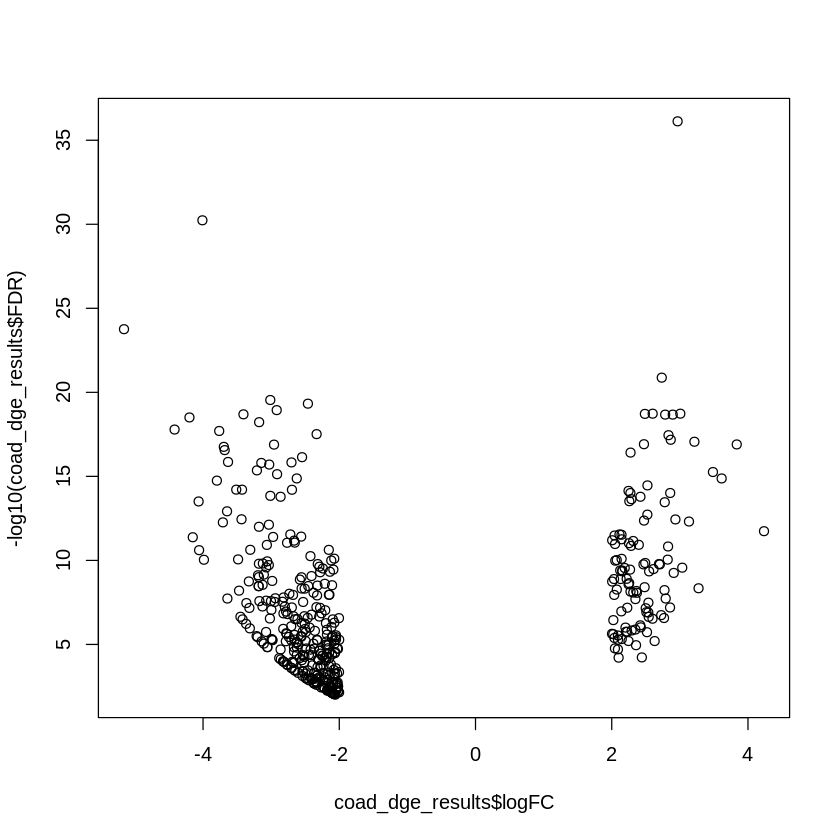

In [26]:
plot(coad_dge_results$logFC,-log10(coad_dge_results$FDR))

#**Heatmap generation by sample clustering**

In [28]:
dim(coad_dge_levels)
head(coad_dge_levels)

[1] 418   8

,mRNA,logFC,FDR,Delta,Primary Tumor,Solid Tissue Normal,start,end
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
ENSG00000183034,ENSG00000183034,2.967196,7.505725e-37,3.905287,1.3161539,11.905368,74922950,74933912
ENSG00000110887,ENSG00000110887,2.275921,3.842523e-17,3.000180,1.3182264,7.334601,108858932,108901043
ENSG00000125851,ENSG00000125851,2.486471,1.915746e-19,2.892622,1.1633444,7.577773,17226107,17484578
ENSG00000034971,ENSG00000034971,2.734225,1.337342e-21,2.635313,0.9638244,7.599835,171635417,171652688
ENSG00000204933,ENSG00000204933,2.600668,1.861084e-19,2.619809,1.0073602,7.199267,43372742,43379123
ENSG00000108231,ENSG00000108231,2.246216,7.313920e-15,2.608309,1.1612010,6.384587,93757840,93806272


In [29]:
# take data from coad_log2norm matrix with rownames by coad_dge_levels
heatmap_data <- head(coad_log2norm[rownames(coad_dge_levels),])

In [30]:
# color the plot by kind of tumor
cancer_type <- c(rep("Primary Tumor",20), rep("Solid Tissue Normal",20))


In [31]:
color_code <- c(rep("Primary Tumor",20), rep("Solid Tissue Normal",20))

In [32]:
color_code <- c()

for(i in cancer_type ){
  if(i == "Primary Tumor"){
    color_code <- c(color_code,"red")
  }else{
     color_code <- c(color_code,"blue")
  }
}

In [33]:
color_code

[1] "red"  "red"  "red"  "red"  "red"  "red"  "red"  "red"  "red"  "red" 
[11] "red"  "red"  "red"  "red"  "red"  "red"  "red"  "red"  "red"  "red" 
[21] "blue" "blue" "blue" "blue" "blue" "blue" "blue" "blue" "blue" "blue"
[31] "blue" "blue" "blue" "blue" "blue" "blue" "blue" "blue" "blue" "blue"

In [34]:
# Specify the output file and dimensions for heapmap

png(filename = "SampleCluster_Heatmap_coadTCGA.png", res = 300, width=1500, height=1200)

heatmap.2(
            x = as.matrix(heatmap_data),                    # data matrix
            dendrogram = "col", # Creates both row and column dendrograms
            Rowv =F, Colv =T,
            scale = "row",  # Scale by row (normalize each row)
            trace = "none",                  # No trace lines inside the heatmap
            col = bluered(100),              # Color scheme (you can choose another one)
            #margins = c(3, 3),               # Adjust margins
            key = TRUE,                      # Show a color key
            cexRow = 0.5,                    # Font size for row labels
            cexCol = 0.5,    # Font size for column labels
            main = "Sample clusters heatmap" ,
            ColSideColors = color_code
)

dev.off()

pdf 
  2

# **Functional analysis**
The analysis was perfomed using **TCGAbiolinks** package, but first the gene names were obtained by runing **useMart()** function from **BiomaRT** package.

In [35]:

# first install biomaRt package

BiocManager::install("biomaRt")
library(biomaRt)


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'biomaRt'”


In [36]:
# convert genes ID to gene names using biomaRt function
mart <- useMart("ensembl",  dataset = "hsapiens_gene_ensembl")
upreg_genes <- getBM(attributes = c("ensembl_gene_id", "hgnc_symbol"),
                   filters = "ensembl_gene_id",
                   values = upreg_genes,
                   mart = mart)$hgnc_symbol

 dnreg_genes <- getBM(attributes = c("ensembl_gene_id", "hgnc_symbol"),
                   filters = "ensembl_gene_id",
                   values = dnreg_genes,
                   mart = mart)$hgnc_symbol

In [37]:
#download upregulated and downregulated genes names
write.csv(upreg_genes,"Uregulated_genes_names.csv")

In [38]:
write.csv(dnreg_genes,"Downregulated_genes_names.csv")

In [39]:
# perform functional enrichment analysis for the upreglated and the downregulated genes using one of TCGAbiolinks functions


upreg_genes_EA <- TCGAanalyze_EAcomplete(TFname = "Upregulated_genes",  upreg_genes)
  dnreg_genes_EA <- TCGAanalyze_EAcomplete(TFname = "Downregulated_genes", dnreg_genes)

[1] "I need about  1 minute to finish complete  Enrichment analysis GO[BP,MF,CC] and Pathways... "
[1] "GO Enrichment Analysis BP completed....done"
[1] "GO Enrichment Analysis MF completed....done"
[1] "GO Enrichment Analysis CC completed....done"
[1] "Pathway Enrichment Analysis completed....done"
[1] "I need about  1 minute to finish complete  Enrichment analysis GO[BP,MF,CC] and Pathways... "
[1] "GO Enrichment Analysis BP completed....done"
[1] "GO Enrichment Analysis MF completed....done"
[1] "GO Enrichment Analysis CC completed....done"
[1] "Pathway Enrichment Analysis completed....done"


In [40]:
# visiualization of the upregulated genes enriched pathways
 TCGAvisualize_EAbarplot(tf= rownames(upreg_genes_EA$ResBP),
           GOBPTab = upreg_genes_EA$ResBP,
           GOCCTab = upreg_genes_EA$ResCC,
           PathTab = upreg_genes_EA$ResPathway,
           nRGTab = upreg_genes_EA$ResRG,
           nBar= 10,
           text.size = 1,
           fig.width = 20,
           fig.height = 12)

# the result was saved to  : "https://github.com/Mariam000v/hackbio-cancer-internship/blob/main/upregulated%20genes%20-EA-result.pdf"


pdf 
  2

In [41]:
# visiualization of the downregulated genes enriched pathways
 TCGAvisualize_EAbarplot(tf= rownames(dnreg_genes_EA$ResBP),
           GOBPTab = dnreg_genes_EA$ResBP,
           GOCCTab = dnreg_genes_EA$ResCC,
           PathTab = dnreg_genes_EA$ResPathway,
           nRGTab = dnreg_genes_EA$ResRG,
           nBar= 10,
           text.size = 1,
           fig.width = 20,
           fig.height = 12)

       # the result was saved to : "https://github.com/Mariam000v/hackbio-cancer-internship/blob/main/downregulated-genes-EA-result.pdf"

pdf 
  2

##**References**

Colaprico A, Silva TC, Olsen C, Garofano L, Cava C, Garolini D, Sabedot T, Malta TM, Pagnotta SM, Castiglioni I, Ceccarelli M, Bontempi G, Noushmehr H (2015). “TCGAbiolinks: An R/Bioconductor package for integrative analysis of TCGA data.” Nucleic Acids Research. doi:10.1093/nar/gkv1507, http://doi.org/10.1093/nar/gkv1507.